In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy

from baseline.utils import evaluate_iou, plot_net
from baseline.templates import loadEmotionTaskDesign, loadMotorTaskDesign, loadEmotionTemplate, loadMotorTemplate, loadRSNTemplate10
from utils.activate import STAIndividual

In [8]:
%%time
sta = STAIndividual(mask_path="/home/public/ExperimentData/HCP900/HCP_data/mask_152_4mm.nii.gz",
                    img_path="/home/public/ExperimentData/HCP900/HCP_data/SINGLE/MOTOR_sub_0.npy",
                    device="cuda:1",
                    model_path="./model_save_dir/hcp_motor_10sub.pth",
                    time_step=40,
                    out_map=64,
                    lr=0.0001) 
sta.load_img()
# sta.fit(epochs=1)
# sta.eval()

CPU times: user 752 ms, sys: 380 ms, total: 1.13 s
Wall time: 518 ms


In [3]:
# sta.load_img()

In [4]:
# sta.fit(epochs=1)

In [5]:
# sta.eval()

In [3]:
template = loadMotorTemplate(threshold=True)
template.shape

(6, 28546)

In [4]:
rsn_template = loadRSNTemplate10(threshold=True)
rsn_template.shape

(10, 28546)

In [5]:
task_design = loadMotorTaskDesign()
task_design.shape

(284, 6)

In [9]:
%%time
from tqdm import trange
iou_max = []
rsn_max = []
for i in trange(sta.imgs.shape[1] - sta.time_step + 1):
    img2d = sta.predict(i)
#     img2d[np.sum(img2d > 0, axis=1) < np.sum(img2d < 0, axis=1), :] *= -1
    img2d[img2d < 3.6] = 0
    iou = evaluate_iou(img2d, template, 0)
    iou_max.append(deepcopy(iou.max(axis=0)))
    iou = evaluate_iou(img2d, rsn_template, 0)
    rsn_max.append(deepcopy(iou.max(axis=0)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [01:42<00:00,  2.39it/s]

CPU times: user 1min 17s, sys: 21.3 s, total: 1min 38s
Wall time: 1min 42s


In [10]:
from random import sample

In [11]:
import scipy

## IoU 随时间变化的曲线以及和任务曲线的相关性

task1, max_iou=0.33620689655172414, pcc=0.2260365047686152, p=0.0003621913314258739


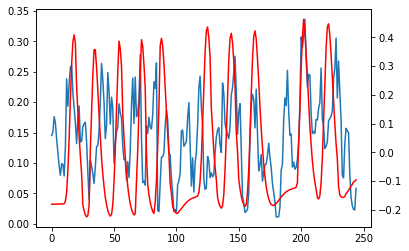

task2, max_iou=0.5608308605341247, pcc=-0.05724164554162395, p=0.3723269321736587


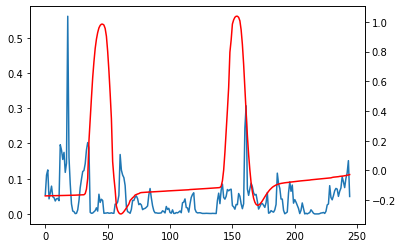

task3, max_iou=0.5366795366795367, pcc=0.4511931532404999, p=1.08826301433223e-13


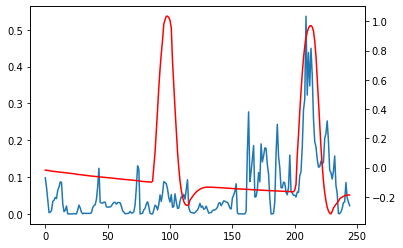

task4, max_iou=0.31592689295039167, pcc=0.15577733758968657, p=0.014656803370613739


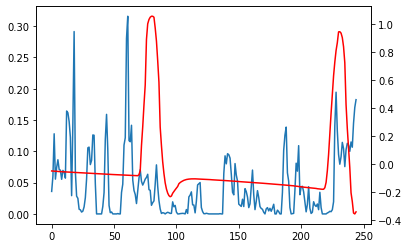

task5, max_iou=0.49583333333333335, pcc=0.21624376910060528, p=0.0006547670305846251


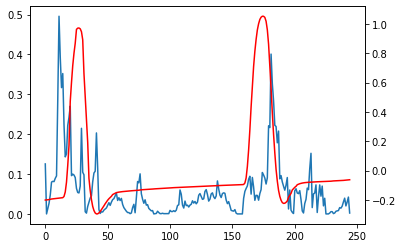

task6, max_iou=0.38716356107660455, pcc=0.516091362028066, p=4.447262779334896e-18


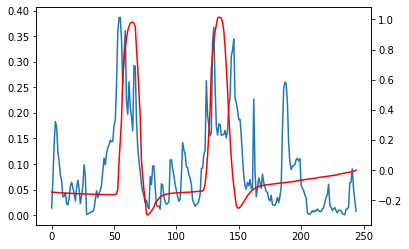

In [13]:
iou_max = np.array(iou_max)
sample_index = sample([i for i in range(task_design.shape[0])], iou_max.shape[0])
sample_index.sort()
for i in range(template.shape[0]):
    corr = scipy.stats.pearsonr(iou_max[:, i], task_design[sample_index, i])
    print(f"task{i+1}, max_iou={iou_max[:, i].max()}, pcc={corr[0]}, p={corr[1]}")
    plt.plot(iou_max[:, i])
    plt.twinx()
    plt.plot(task_design[sample_index, i], color="red")
    plt.show()

In [14]:
iou_max.shape

(245, 6)

In [15]:
iou_max.argmax(0)

array([203,  18, 209,  61,  11,  55])

In [16]:
iou_max.max(0)

array([0.3362069 , 0.56083086, 0.53667954, 0.31592689, 0.49583333,
       0.38716356])

# Motor FBN

In [20]:
from nilearn.plotting import plot_stat_map, show
from nilearn.image import iter_img
def plot_ortho_net(component_imgs, colorbar=0, verbose=0):
    for i, cur_img in enumerate(iter_img(component_imgs)):
        if verbose:
            print(i)
        plot_stat_map(cur_img, display_mode="ortho",
                      cut_coords=None, colorbar=colorbar, annotate=1, black_bg=1, draw_cross=1)
        show()

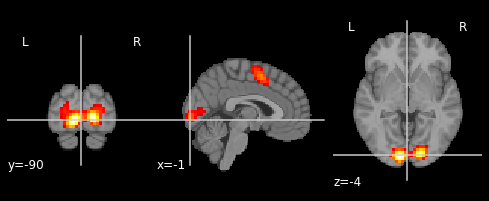

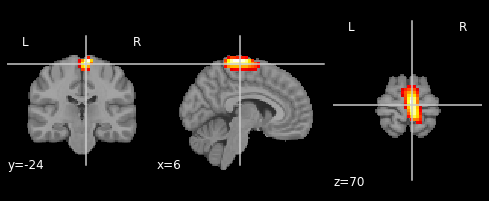

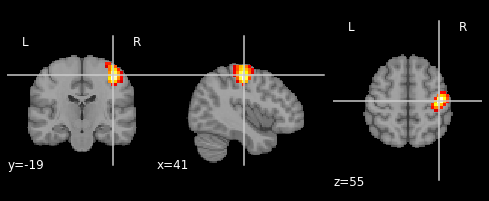

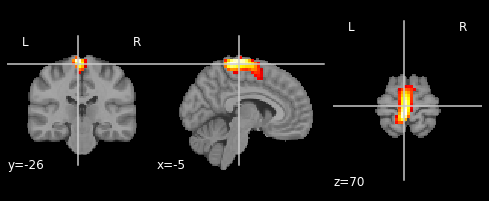

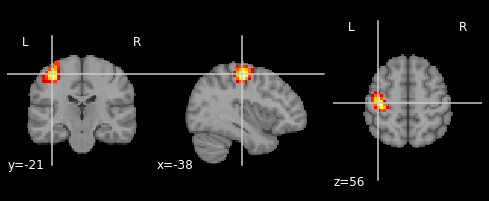

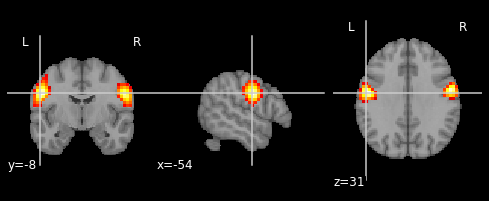

In [21]:
plot_ortho_net(sta.img2NiftImage(template))


Template	1	2	3	4	5	6	
IoU		0.3362	0.0155	0.0587	0.0192	0.0508	0.0397	
Index		45	7	9	7	7	7	


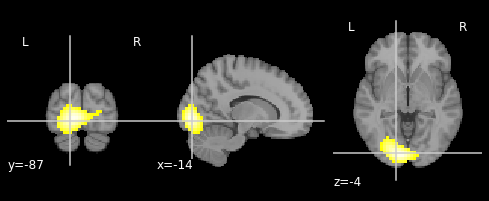


Template	1	2	3	4	5	6	
IoU		0.1917	0.5608	0.0000	0.2915	0.2219	0.0426	
Index		6	58	0	58	38	38	


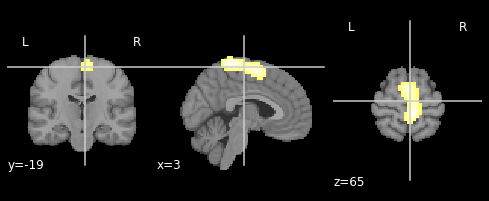


Template	1	2	3	4	5	6	
IoU		0.1481	0.0019	0.5367	0.0027	0.0365	0.0087	
Index		36	63	45	63	0	51	


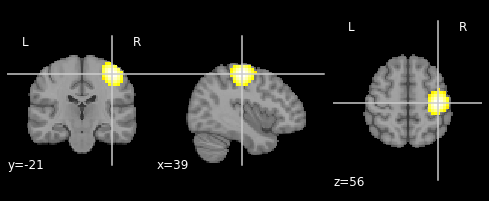


Template	1	2	3	4	5	6	
IoU		0.1021	0.1242	0.0205	0.3159	0.0389	0.1972	
Index		5	48	59	48	13	52	


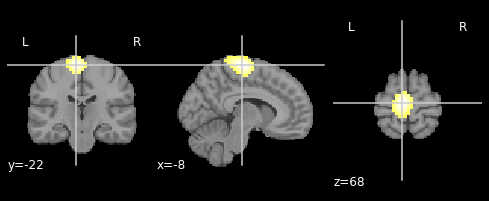


Template	1	2	3	4	5	6	
IoU		0.1263	0.0376	0.0729	0.0572	0.4958	0.0439	
Index		28	63	38	63	11	38	


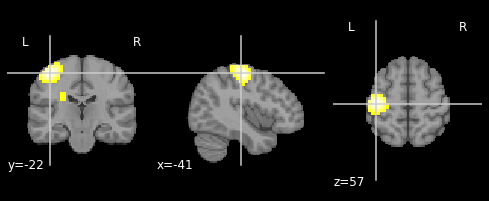


Template	1	2	3	4	5	6	
IoU		0.1823	0.0019	0.0312	0.0000	0.0383	0.3872	
Index		18	45	27	0	43	47	


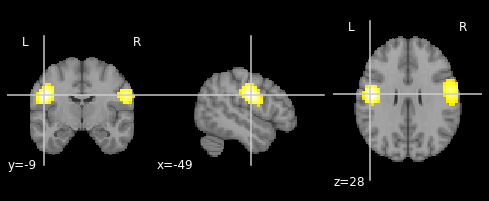

In [22]:
for i in range(6):
    img2d = sta.predict(iou_max.argmax(0)[i])
    img2d[img2d < 3.6] = 0
    iou = evaluate_iou(img2d, template)
    plot_ortho_net(sta.img2NiftImage(img2d[iou.argmax(0)[i]: iou.argmax(0)[i] + 1, :]))

## IoU with RSN template

In [17]:
rsn_max = np.array(rsn_max)
rsn_max.max(0)

array([0.54931261, 0.360519  , 0.30733411, 0.36983155, 0.32399103,
       0.37629789, 0.30245428, 0.27209763, 0.3125    , 0.2780233 ])

In [18]:
rsn_max.argmax(0)

array([156,  74, 214, 197, 135,   7, 198, 212,  79, 213])


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.5493	0.2973	0.1508	0.2174	0.0775	0.0828	0.1946	0.0861	0.1093	0.0427	
Index		45	20	14	36	14	29	5	0	0	43	


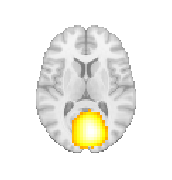


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.3353	0.3605	0.1857	0.1540	0.0758	0.0453	0.1284	0.0323	0.1984	0.1157	
Index		54	24	16	47	62	29	5	5	5	43	


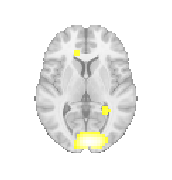


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.1762	0.2607	0.3073	0.1678	0.0842	0.0830	0.0729	0.1660	0.0575	0.2721	
Index		53	58	30	9	48	3	43	51	25	18	


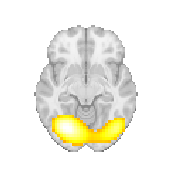


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.1125	0.2056	0.2044	0.3698	0.0600	0.1146	0.2803	0.1543	0.0510	0.0801	
Index		54	29	18	37	14	44	48	55	0	41	


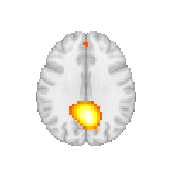


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.2663	0.2926	0.1731	0.0260	0.3240	0.0678	0.0740	0.1171	0.0095	0.0158	
Index		42	45	30	54	41	5	0	16	0	5	


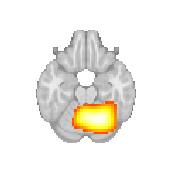


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.1228	0.1011	0.1011	0.1319	0.0306	0.3763	0.2607	0.1748	0.1033	0.0465	
Index		41	45	55	21	50	49	57	16	56	28	


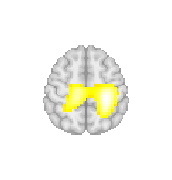


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.1367	0.1790	0.2100	0.3098	0.0650	0.1513	0.3025	0.1531	0.0671	0.0958	
Index		6	29	18	37	16	44	48	55	0	41	


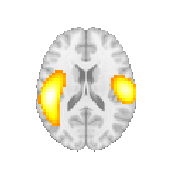


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.1922	0.2872	0.2630	0.1113	0.0608	0.1679	0.0914	0.2721	0.0418	0.2430	
Index		8	58	41	45	41	5	16	45	25	16	


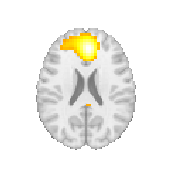


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.3873	0.0813	0.1565	0.1387	0.0345	0.0284	0.1272	0.0537	0.3125	0.0431	
Index		29	16	16	14	16	55	55	18	37	55	


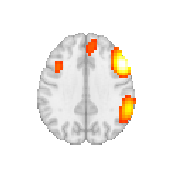


Template	1	2	3	4	5	6	7	8	9	10	
IoU		0.1981	0.3035	0.2885	0.1331	0.0807	0.0835	0.0866	0.1977	0.0627	0.2780	
Index		17	56	53	45	1	37	16	57	25	29	


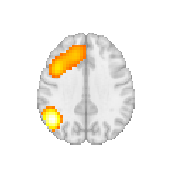

In [19]:
for i in range(10):
    img2d = sta.predict(rsn_max.argmax(0)[i])
    img2d[img2d < 3.6] = 0
    iou = evaluate_iou(img2d, rsn_template)
    plot_net(sta.img2NiftImage(img2d[iou.argmax(0)[i]: iou.argmax(0)[i] + 1, :]), annotate=0, colorbar=0, cut_coords=1)

In [22]:
sta.save_model(model_path="./model_save_dir/hcp_motor_0.pth")